In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torchvision
import torch.nn.functional as F




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class AnimeDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_filenames = os.listdir(self.data_dir)
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.image_filenames[idx])
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)
        
        return image

transform = transforms.Compose([
    transforms.Resize((64, 64)),     # Resize to 64x64 pixels
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize between [-1, 1]
])

dataset = AnimeDataset(data_dir="C:/Users/user/Desktop/LEARN/Model Mimarileri/GAN/anime_faces", transform=transform)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)

In [3]:
len(dataloader)

497

In [4]:
dataset[0].shape

torch.Size([3, 64, 64])

In [5]:
249*256

63744

In [6]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Hyperparameters
nz = 100  # Size of the latent vector (input to the generator)
lr = 0.0002  # Learning rate
beta1 = 0.5  # Beta1 for Adam optimizer

# Initialize the models
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
# Labels for real and fake images
real_label = 1
fake_label = 0

# Number of epochs
num_epochs = 100

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # Train with real images
        netD.zero_grad()
        real_images = data.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        
        output = netD(real_images).view(-1)
        lossD_real = criterion(output, labels)
        lossD_real.backward()
        
        # Train with fake images
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        labels.fill_(fake_label)
        
        output = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, labels)
        lossD_fake.backward()
        
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # We want the generator to produce "real" labels
        
        output = netD(fake_images).view(-1)
        lossG = criterion(output, labels)
        lossG.backward()
        
        optimizerG.step()
        
        # Print statistics
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Step [{i}/{len(dataloader)}] "
                  f"Loss D: {lossD_real.item() + lossD_fake.item()}, Loss G: {lossG.item()}")

Epoch [0/100] Step [0/497] Loss D: 1.423405945301056, Loss G: 2.29728364944458
Epoch [0/100] Step [100/497] Loss D: 0.34721076488494873, Loss G: 2.8258275985717773
Epoch [0/100] Step [200/497] Loss D: 1.4493194073438644, Loss G: 7.434690475463867
Epoch [0/100] Step [300/497] Loss D: 0.2936823144555092, Loss G: 4.34830904006958
Epoch [0/100] Step [400/497] Loss D: 0.795203723013401, Loss G: 7.251509666442871
Epoch [1/100] Step [0/497] Loss D: 0.6991699934005737, Loss G: 5.441246032714844
Epoch [1/100] Step [100/497] Loss D: 0.6850224742665887, Loss G: 5.505003929138184
Epoch [1/100] Step [200/497] Loss D: 1.150671862065792, Loss G: 9.753702163696289
Epoch [1/100] Step [300/497] Loss D: 0.3397374264895916, Loss G: 2.665125846862793
Epoch [1/100] Step [400/497] Loss D: 0.40279141068458557, Loss G: 5.037847995758057
Epoch [2/100] Step [0/497] Loss D: 0.3120117112994194, Loss G: 5.217589855194092
Epoch [2/100] Step [100/497] Loss D: 0.37883681058883667, Loss G: 5.216751575469971
Epoch [2/10

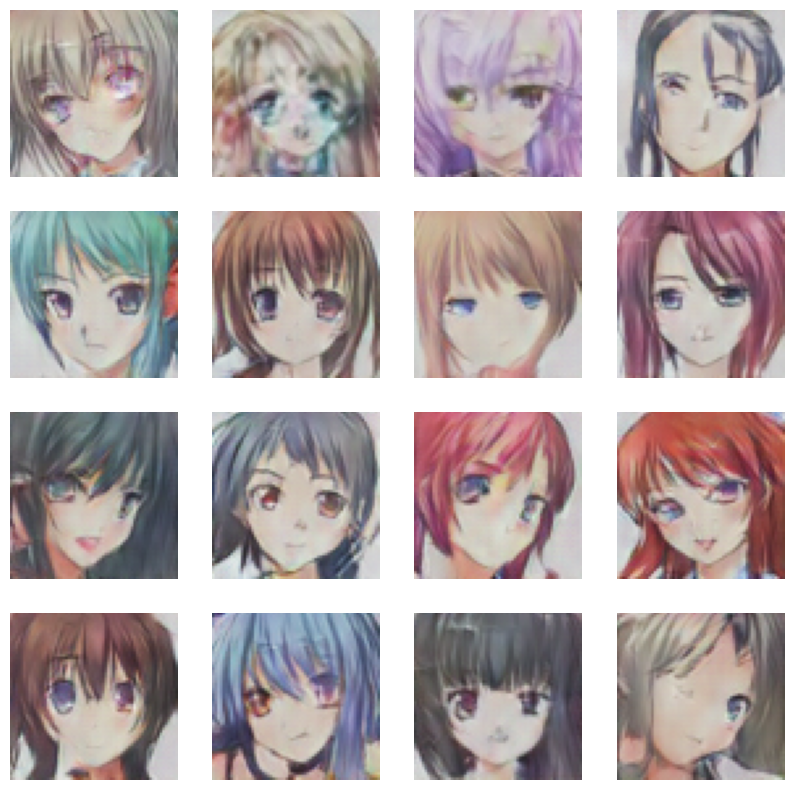

In [38]:
# Generate a batch of images from random noise
with torch.no_grad():
    noise = torch.randn(128, nz, 1, 1, device=device)
    fake_images = netG(noise).detach().cpu()

# Plot the generated images
grid = np.transpose(fake_images, (0, 2, 3, 1))  # Rearrange dimensions for plotting
grid = (grid + 1) / 2  # Unnormalize from [-1, 1] to [0, 1]

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(grid[i])
    ax.axis('off')
plt.show()